In [19]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from collections import deque

# Import stable baselines
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env, SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env

from Environment.env_v10 import *
from Functions.visualization_functions import *

In [20]:
# Configuration of the network
with open('./Config/network_config_v2.json') as file:
    network_config = file.read()

EP_LENGTH = 100

In [21]:
def load_config(config_file):

    with open(config_file, "r") as f:
        config = json.load(f)
    return config

def make_env(config_file="config.json"):

    config = load_config(config_file)

    env = SS_Mngmt_Env(
        network_config=network_config,
        EP_LENGTH=EP_LENGTH,
        render_mode="human",
        model_type="PPO",
        stockout_cost=config["stockout_cost"],
        order_cost=config["order_cost"],
        item_cost=config["item_cost"],
        stock_cost=config["stock_cost"],
        item_prize=config["item_prize"],
        progressive_stock_cost=config["progressive_stock_cost"],
        stock_out_max=config["stock_out_max"],
        order_quantities=config["order_quantities"],
        demand_mean=config["demand_mean"],
        demand_std=config["demand_std"],
        demand_noise=config["demand_noise"],
        demand_noise_std=config["demand_noise_std"],
        demand_prob=config["demand_prob"],
        extreme=True,
        seasonality=True,
        intermediate_reward=0,
    )

    env = Monitor(env)

    return env

env = make_env("./Config/env_config_v0.json")
check_env(env, warn=True)

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation order_queues has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_network to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_network` for environment variables or `env.get_wrapper_attr('render_network')` that will search the reminding wrappers.
  logger.warn(


Node Attributes:
Node A: {'type': 'manufacturer', 'I': 30}
Node B: {'type': 'manufacturer', 'I': 30}
Node C: {'type': 'manufacturer', 'I': 30}
Node E: {'type': 'manufacturer', 'I': 100}
Node F: {'type': 'manufacturer', 'I': 100}
Node G: {'type': 'manufacturer', 'I': 100}
Node D: {'type': 'distributor'}
Node S: {'type': 'source'}


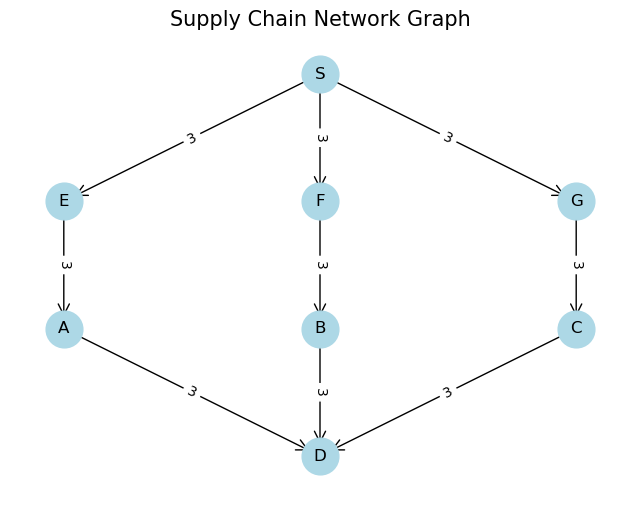

In [22]:
env.render_network()

In [23]:
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score += reward

        env.render()

**************************************************

Episode Information
Episode Length: 1
Stock Level (Previous Timestep): [30.0, 30.0, 30.0, 100.0, 100.0, 100.0]
Stock Level: [ 31.  45.  45. 100. 115.  65.]
Planned Demand: [12.  0.  0.]
Actual Demand: [14.  0.  0. 15.  0. 50.]
Action: [15, 0, 50, 100, 50, 0]
Deliveries: [15 15 15 15 15 15]
Step Reward: 237.89
Total Reward: 237.89

Backlog:
[False, False, False, False, False, False]

Order Queue:
{   'A': deque([0, 0, 15], maxlen=3),
    'B': deque([0, 0, 0], maxlen=3),
    'C': deque([0, 0, 50], maxlen=3),
    'E': deque([0, 0, 100], maxlen=3),
    'F': deque([0, 0, 50], maxlen=3),
    'G': deque([0, 0, 0], maxlen=3)}


Stockout Counter:  0
**************************************************

Episode Information
Episode Length: 2
Stock Level (Previous Timestep): [31.0, 45.0, 45.0, 100.0, 115.0, 65.0]
Stock Level: [31. 45. 31.  0. 65.  0.]
Planned Demand: [0. 0. 9.]
Actual Demand: [  0.   0.  14. 100.  50. 100.]
Action: [100, 50, 100, 1

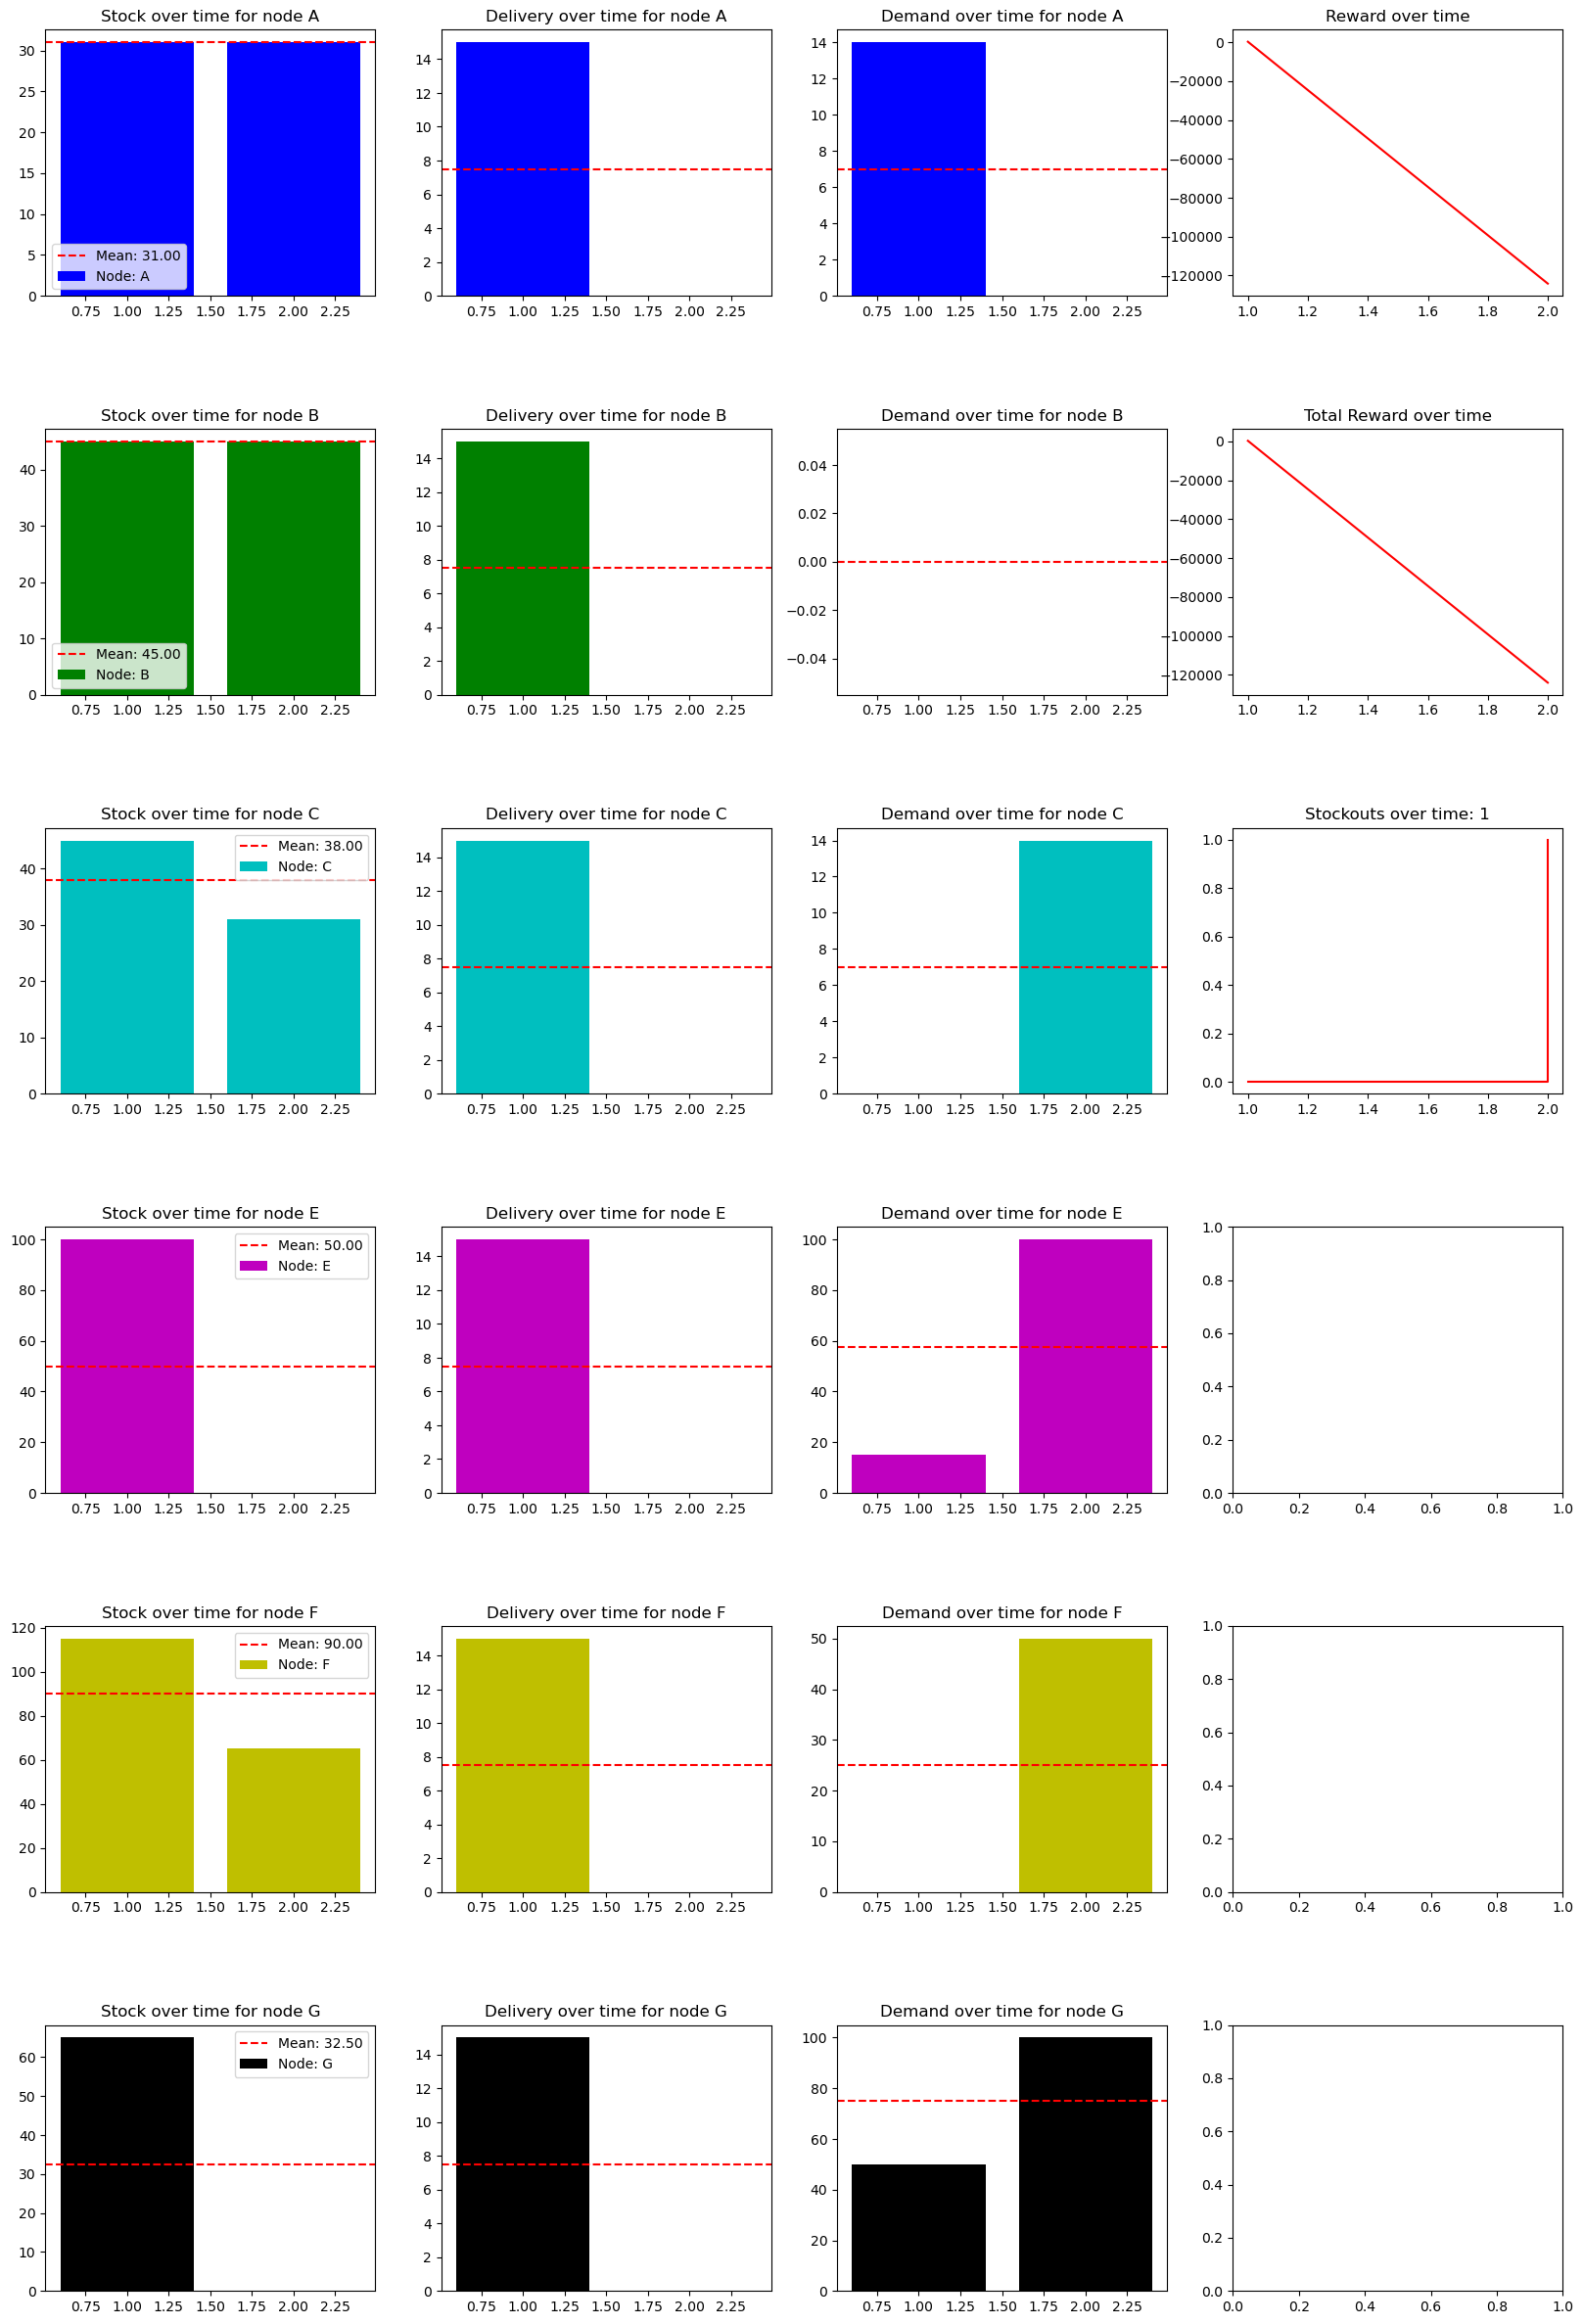

In [24]:
df = pd.read_csv('./Data/2024-12-16_environment_data_PPO.csv')
plot_data(df)

In [25]:
log_path = os.path.join('Training', 'Test', 'Logs')
model_path = os.path.join('Training', 'Test', 'Models', 'PPO')

In [26]:
vec_env = DummyVecEnv([lambda: make_env("./Config/env_config_v0.json")])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=10.0)

# num_envs = 8
# envs = SubprocVecEnv([make_env for _ in range(num_envs)])
# vec_env = VecNormalize(envs, norm_reward=True)

model = PPO(
    "MultiInputPolicy", 
    vec_env,
    verbose=0,
    learning_rate=0.0003 ,
    gamma=0.99,
    clip_range=0.2,
    ent_coef=0.01,
    vf_coef=0.5,
    n_steps=2048,
    batch_size=64,
    tensorboard_log=log_path,
    )

# model = A2C("MultiInputPolicy",
#             vec_env, 
#             learning_rate=lambda f: 0.0003 * (1 - f),
#             gamma=0.99,
#             n_steps=20,
#             ent_coef=0.05,
#             vf_coef=0.7,
#             max_grad_norm=0.5,
#             tensorboard_log=log_path,
#             verbose=0)

In [27]:
model.learn(total_timesteps=800_000)

In [36]:
evaluate_policy(model, vec_env, n_eval_episodes=10, render=False, return_episode_rewards=True)

([-50140.66,
  -79810.81,
  -44370.57,
  -115577.98,
  -76314.51,
  -66248.28,
  -77074.47,
  -55201.93,
  -64156.43,
  -73867.24],
 [100, 63, 100, 4, 59, 100, 100, 100, 100, 100])

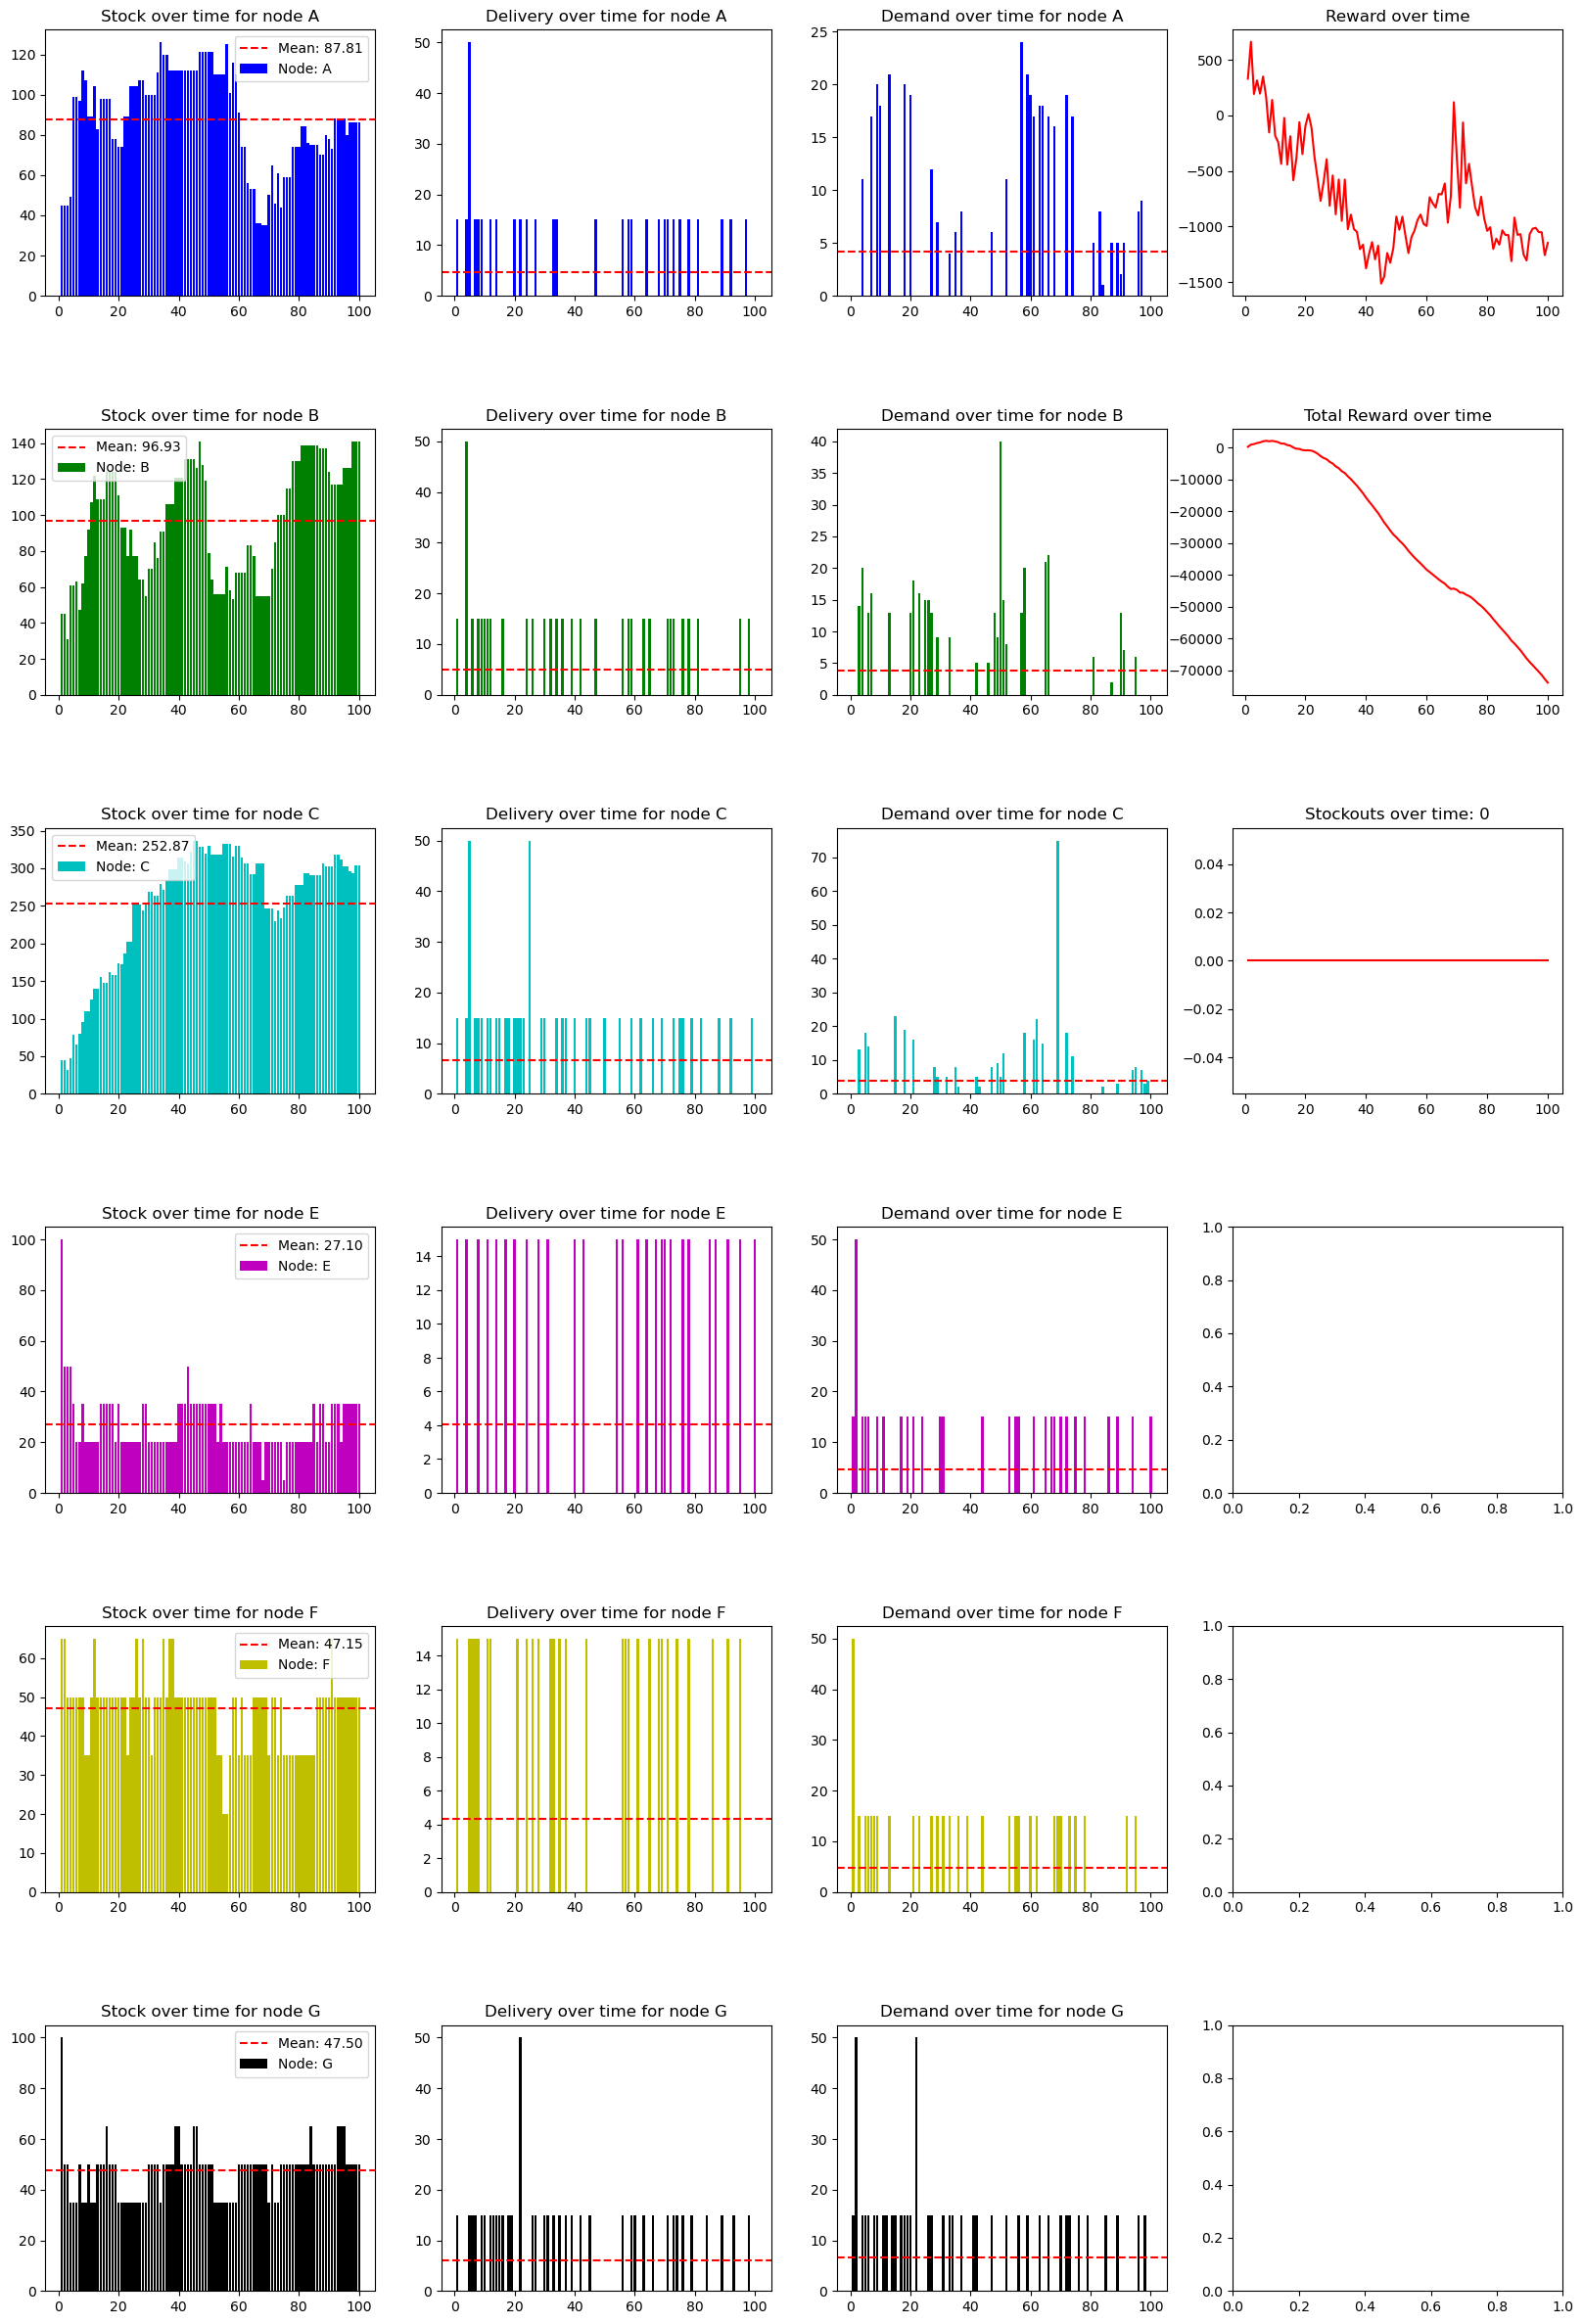

In [37]:
df = pd.read_csv('./Data/2024-12-16_environment_data_PPO.csv')

plot_data(df)